pipline 将 预处理输入，将输入送往model，后输入 打包在一起。

In [1]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

d:\Anaconda\envs\nlp\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
d:\Anaconda\envs\nlp\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
d:\Anaconda\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a n

[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

### 通过分词器来预处理

通过checkpoint获取分词器

In [2]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

d:\Anaconda\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


`return_tensors` 参数可以指定返回的张量类型

In [3]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
#返回字典
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


tokenizer返回字典。字典中包含有两个key。在input_ids中每条句子对应1维的vector，每个元素是每个token的唯一标识

### 将预处理的结果传递给模型

加载预训练的模型

In [4]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

transformer model 的输出是一个高维向量（hidden states or features），该向量代表了对输入内容的上下文理解。通包含三个维度
- Batch size
- Sequence length
- Hidden size: 代表了model输出向量的维度

model的输出通常会被送往head。在不同的任务中，transformer的架构通常相同，但head不同

In [8]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


model的输出类似于字典，可以通过key或者index来访问元素

In [10]:
outputs["last_hidden_state"], outputs[0]

(tensor([[[-0.1798,  0.2333,  0.6321,  ..., -0.3017,  0.5008,  0.1481],
          [ 0.2758,  0.6497,  0.3200,  ..., -0.0760,  0.5136,  0.1329],
          [ 0.9046,  0.0985,  0.2950,  ...,  0.3352, -0.1407, -0.6464],
          ...,
          [ 0.1466,  0.5661,  0.3235,  ..., -0.3376,  0.5100, -0.0561],
          [ 0.7500,  0.0487,  0.1738,  ...,  0.4684,  0.0030, -0.6084],
          [ 0.0519,  0.3729,  0.5223,  ...,  0.3584,  0.6500, -0.3883]],
 
         [[-0.2937,  0.7283, -0.1497,  ..., -0.1187, -1.0227, -0.0422],
          [-0.2206,  0.9384, -0.0951,  ..., -0.3643, -0.6605,  0.2407],
          [-0.1536,  0.8988, -0.0728,  ..., -0.2189, -0.8528,  0.0710],
          ...,
          [-0.3017,  0.9002, -0.0200,  ..., -0.1082, -0.8412, -0.0861],
          [-0.3338,  0.9674, -0.0729,  ..., -0.1952, -0.8181, -0.0634],
          [-0.3454,  0.8824, -0.0426,  ..., -0.0993, -0.8329, -0.1065]]],
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[[-0.1798,  0.2333,  0.6321,  ..., -0.3017,  0.

Model heads: Making sense out of numbers

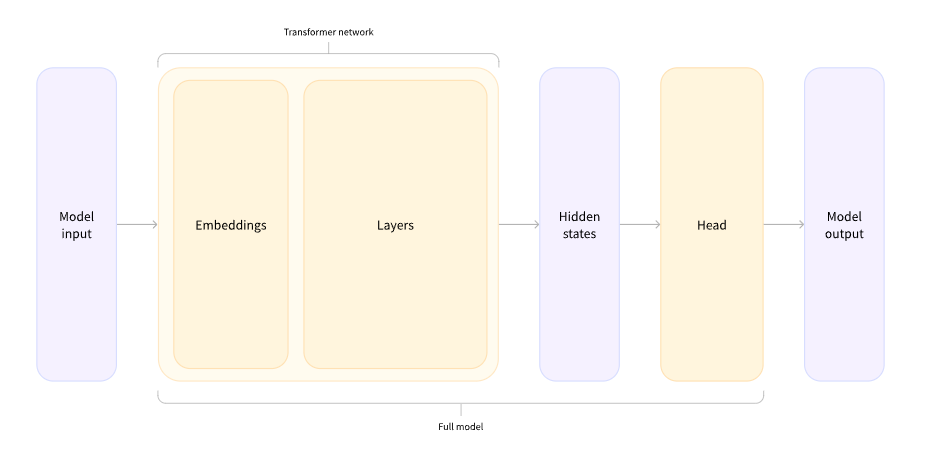

model head通常由多个线性层组成。model head将hidden states转换为我们想要的数学结果.

对于情感分类问题，我们需要`sequence classification head`

In [12]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

d:\Anaconda\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
print(outputs["logits"].shape)

torch.Size([2, 2])


后处理输出

在深度学习中，​​logits​​ 是指模型最后一层（通常是全连接层或输出层）输出的​​原始未归一化分数​​，
尚未经过激活函数（如 Softmax 或 Sigmoid）处理。在分类任务中，logits 的绝对值大小表示模型对某类别的置信度（值越大，倾向性越强）

为了将logits转换为概率，我们还需要使用softmax激活函数. 训练时的处理​​：在训练阶段，损失函数（如交叉熵损失）会​​将SoftMax激活与损失计算合并​​（即nn.CrossEntropyLoss已内置SoftMax），而非分开执行.

In [15]:
import torch
prediction = torch.nn.functional.softmax(outputs['logits'],dim=-1)
print(prediction)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


可以通过 model.config 中的 `id2label` 属性来获取每一列对应的label

In [16]:
print(model.config.id2label)

{0: 'NEGATIVE', 1: 'POSITIVE'}


至此我们已经成功复现pipeline背后的三步操作： 

preprocessing with tokenizers, passing the inputs through the model, and postprocessing!